# Byggingagreining á gervitunglamyndum
Nathan HK

In [87]:
from io import BytesIO
import math
import matplotlib.pyplot as plt
from PIL import Image
from pyrosm import OSM
from pyrosm import get_data
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from shapely.geometry import Point
import time

## Inngangsorð
Við viljum þjálfa gervigreindarlíkan til að greina byggingar á gervitunglamyndum. Við þurfum tvenn gögn: gervitunglamyndir og staðsetningar bygginga.

## Gervitunglamyndir
Þessar myndir eru frá skjámyndatökum af Já.is. Ég veit ekki hvort þetta sé löglegt, en ég er ekki með neinar betri leiðir.

In [50]:
hnit = (64.132737, -21.886075)  # TEMP
skhn = (746, 861)  # TEMP

In [52]:
driver = webdriver.Chrome()
driver.set_window_size(1500, 1000)
driver.get('https://ja.is/kort/?x=356954&y=408253&nz=17.00&type=aerialnl')
btn = driver.find_element(By.XPATH, '//a[@id="gdpr_banner_ok"]')
btn.click()
leit = driver.find_element(By.XPATH, '//input[@id="mapq"]')
leit.send_keys(str(hnit[0]) + ', ' + str(hnit[1] + 0.002))
leit.send_keys(Keys.RETURN)
time.sleep(2)
driver.save_screenshot('/Users/002-nathan/Desktop/Envalys/gtm/' + str(hnit[0]) + '_' + str(hnit[1]) + '.png')
skmynd = Image.open('/Users/002-nathan/Desktop/Envalys/gtm/' + str(hnit[0]) + '_' + str(hnit[1]) + '.png')
skmynd = skmynd.crop((skhn[0] - 512, skhn[1] - 512, skhn[0] + 512, skhn[1] + 512))
skmynd.save('/Users/002-nathan/Desktop/Envalys/gtm/' + str(hnit[0]) + '_' + str(hnit[1]) + '.png')
driver.close()

## Staðsetningar bygginga
Við notum OpenStreetMap fyrir þetta.

In [57]:
fp = get_data('Iceland')

In [62]:
y_n = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[0]) / 2))) - 0.5
y_s = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[0]) / 2))) + 0.5

In [64]:
osm = OSM(fp, bounding_box=[hnit[1] - 0.001373,
                            math.degrees(2 * (math.atan(math.exp(math.pi - y_s * 2 * math.pi / (2 ** 17))) - math.pi / 4)),
                            hnit[1] + 0.001373,
                            math.degrees(2 * (math.atan(math.exp(math.pi - y_n * 2 * math.pi / (2 ** 17))) - math.pi / 4))])
byggingar = osm.get_buildings()

## Samansett

In [96]:
def pix2coord(pix, hnit):
    x_t = 1 / (2 * math.pi) * 2 ** 17 * (math.pi + math.radians(hnit[1])) + (pix[0] - 512) / 1024
    lon = math.degrees(x_t * 2 * math.pi / (2 ** 17) - math.pi)
    y_t = 1 / (2 * math.pi) * 2 ** 17 * (math.pi - math.log(math.tan(math.pi / 4 + math.radians(hnit[0]) / 2))) + (pix[1] - 512) / 1024
    lat = math.degrees(2 * (math.atan(math.exp(math.pi - y_t * 2 * math.pi / (2 ** 17))) - math.pi / 4))
    return (lat, lon)

0 0.0001690387725830078
100 17.865789890289307
200 36.90197706222534
300 56.93180203437805
400 76.30046319961548
500 96.28438091278076
600 114.76331210136414
700 135.6247820854187
800 154.52264189720154
900 174.4153289794922
1000 194.1727259159088


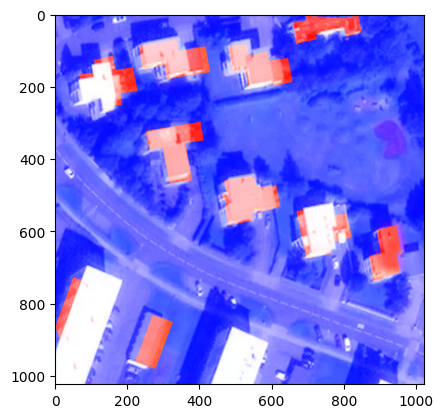

In [98]:
gtm = Image.open('/Users/002-nathan/Desktop/Envalys/gtm/' + str(hnit[0]) + '_' + str(hnit[1]) + '.png')
dilar = gtm.load()
byrjun = time.time()
for i in range(1024):
    if i % 100 == 0:
        print(i, time.time() - byrjun)
    for j in range(1024):
        coord = pix2coord((i, j), hnit)
        f = True
        for k in range(byggingar.shape[0]):
            if byggingar['geometry'][k].contains(Point(coord[1], coord[0])):
                gtm.putpixel((i, j), (max(dilar[i,j][0] + 64, 255), dilar[i,j][1], dilar[i,j][2]))
                f = False
                break
        if f:
            gtm.putpixel((i, j), (dilar[i,j][0], dilar[i,j][1], max(dilar[i,j][2] + 64, 255)))
gtm.save('/Users/002-nathan/Desktop/Envalys/gtm/saman_' + str(hnit[0]) + '_' + str(hnit[1]) + '.png')
plt.imshow(gtm)

## Lokaorð
Við erum með forrit sem sækir gervitunglamyndir og kort af staðsetningum bygginga á mjög nákvæman hátt. Þetta er allt sem við þurfum til að þjálfa gervigreindarlíkan.